In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sb
import os,re
from string import punctuation
import random
from tqdm import tqdm
import pickle
import pandas as pd
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split


def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)
    
tf.config.list_physical_devices('GPU')

2024-12-01 23:48:02.188536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 23:48:02.203908: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 23:48:02.208516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 23:48:02.219460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 23:48:03.018851: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
def preprocess_text(x,tweet=False):
    """
    cleaning tweets -> 
    @user -> USER
    urls -> LINK
    keep only !,.:#? and add space 
    """
    x = str(x).replace('&amp;','and').replace('<br />','').replace('&quot;','').lower()
    x = re.sub(r'&#x[0-9A-Fa-f]+;','',x)
    x = re.sub(r'&#\d+;',"'",x)
    x = re.sub(r'[^\x00-\x7F]+', "'",x)
    
    url_pattern = r'http\S+|www\S+'
    x = re.sub(url_pattern, 'LINK', x).split()
    for i,w in enumerate(x):
        if '@' in w:
            x[i] = 'USER'
    x = ' '.join(x)
    punct_to_keep = """!,.:#?"-;//%$'"""
    punct = ''.join([p for p in punctuation if p not in punct_to_keep])
    trans = str.maketrans(punct, ' ' * len(punct))
    x = x.translate(trans)
    x = ''.join(x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])\s*\1+', r'\1', x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', x)
    x = re.sub(r'\s+', ' ', x).strip().replace("'s "," 's ")
    x = x.replace("\\'"," '").replace("'"," ' ")
    x = x + ' '
    return re.sub(r'\s+', ' ', x).strip()

In [4]:
df = pd.read_csv('/home/bibek/dataset/train.csv')
df['cleaned_text'] = df.text.apply(lambda x: preprocess_text(x))

In [5]:
from custom_tokenizer import BytePairEncodingTokenizer
import json

# load and initialize tokenizer
tokenizer = BytePairEncodingTokenizer()
tokenizer.load_tokenizer('tokenizer.pkl')
tokenizer.maxlen = 128

# load roberta config
with open('roberta_config.json','r') as f:
    config = json.load(f)

# load pretrained weights
with open('roberta_weights.pkl','rb') as f:
    weights = pickle.load(f)

In [6]:
# tokenize sequences
seqs = [tokenizer.tokenize(x) for x in tqdm(df.cleaned_text)]
seqs = [tokenizer.add_padding(x) for x in seqs]
seqs = np.array(seqs,dtype=np.int16)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:07<00:00, 1019.71it/s]


In [7]:
xtrain,xtest,ytrain,ytest = train_test_split(seqs,df.target,train_size=0.75,random_state=0)

In [8]:
from bert import BERT

maxlen = 128
batch = 32//2

roberta = BERT(**config)

reset_random_seeds()

i = tf.keras.layers.Input((maxlen,),batch_size=batch)
x = roberta(i)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(i,x)

model.summary()

 

I0000 00:00:1733077196.034319   13615 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733077196.034601   13615 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733077196.034752   13615 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733077196.097611   13615 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (16, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bert (BERT)                     │ (16, 128, 256)         │     6,737,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (16, 256)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (16, 1)                │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,737,665 (25.70 MB)

 Trainable params: 6,737,665 (25.70 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# set pretrained weights
model.layers[1].set_weights(weights)

# freeze postional encoding weights
roberta.embedding.pos_emb_layer.trainable = False

In [10]:
@tf.function
def train_step(x,y,model):
    with tf.GradientTape() as tape:
        pred = model(x,training=True)
        loss = loss_fn(y,pred)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss


@tf.function
def test_step(x,y,model):
    pred = model(x,training=False)
    loss = loss_fn(y,pred)
    return loss

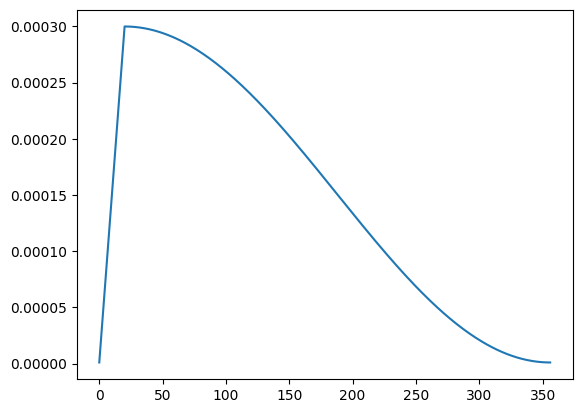

In [11]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.AdamW(weight_decay=0.01,beta_2=0.98,epsilon=1e-6)


class CosineLRScheduler:
    def __init__(self,total_steps,max_lr=3e-4,min_lr=1e-6,init_lr=1e-6):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.init_lr = init_lr
        self.total_setps = total_steps
        self.warmup = int(total_steps * 0.06)
        self.decay = total_steps - self.warmup
        self.warmup_lr = np.linspace(init_lr,max_lr,self.warmup)
        
        
    def __call__(self,step):
        
        if step <= self.warmup:
            
            lr = self.warmup_lr[step-1]
        else:   
            step = step - self.warmup
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(step * np.pi / self.decay))
        
        return lr



total_steps = len(xtrain) // batch + 1
    

train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
train = train.batch(batch_size=batch).shuffle(buffer_size=100)

valid = tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=batch)
# test = tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=batch)


# lr_decay = [cosine_lr_decay(s,total_setps=total_steps,max_lr=3e-4,min_lr=0) for s in range(1,total_steps+1)]

lr_scheduler = CosineLRScheduler(total_steps)

# lr_scheduler(152)
plt.plot([lr_scheduler(i) for i in range(1,total_steps+1)])


In [212]:
epochs = 3

losses = {'train':[],'valid':[]}
check = []
for e in range(1,epochs+1):
    
    print(f'EPOCH : {e}/{epochs}')
    
    loss = 0
    for i,(x,y) in enumerate(tqdm(train)):
        lr = lr_scheduler(i+1)
        opt.learning_rate.assign(lr)
        loss += train_step(x,y,model)
        
    train_loss = np.round((loss / (i+1)).numpy(),4)
    
    losses['train'].append(train_loss)
    
    loss = 0
    for i,(x,y) in enumerate(valid):
        loss += test_step(x,y,model)
        
    
    loss = np.round((loss / (i+1)).numpy(),4) 
    
    print('train_loss :',train_loss)
    print('val_loss :',loss)
    
    if e == 1:
        model.save_weights(f'roberta_weights.weights.h5')
        print('weights saved')
        
    elif e > 1 and min(losses['valid']) > loss:
        model.save_weights(f'roberta_weights.weights.h5')
        print('weights saved')
    
    losses['valid'].append(loss)
    print()

EPOCH : 1/3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2344/2344 [00:55<00:00, 42.53it/s]


train_loss : 0.4584
val_loss : 0.3407
weights saved

EPOCH : 2/3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2344/2344 [00:48<00:00, 48.54it/s]


train_loss : 0.3017
val_loss : 0.3274
weights saved

EPOCH : 3/3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2344/2344 [00:48<00:00, 48.41it/s]


train_loss : 0.2252
val_loss : 0.3472



In [213]:
model.load_weights('roberta_weights.weights.h5')

In [214]:
preds = []
for i,(x,y) in enumerate(valid):
    
    p = np.round(model(x).numpy()[:,0])
    preds.extend(p)
    
print(classification_report(ytest,preds))
print('f1_score :',f1_score(ytest.values,preds))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6291
           1       0.85      0.86      0.86      6209

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500

f1_score : 0.8551491819056786


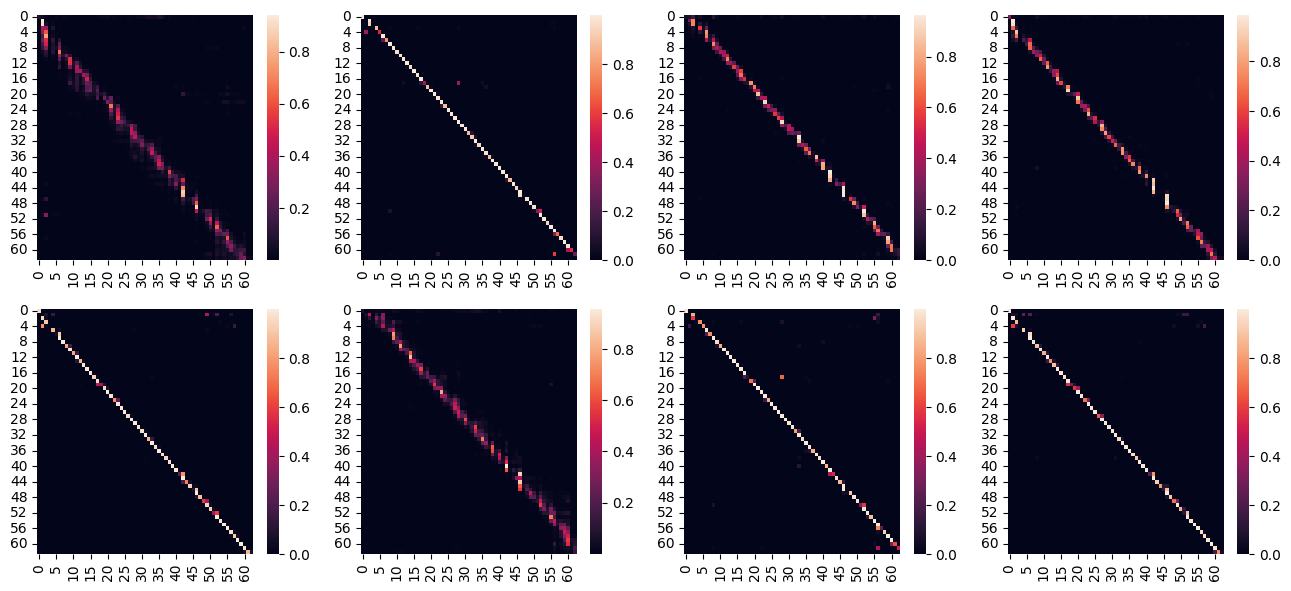

In [215]:
i = np.random.randint(0,len(xtest)-1)
x = xtest[i][np.newaxis,:]
model(x)

idx = np.where(x[0]!=0)[0][-1]

attn_scores = model.layers[1].encoder_layers[-1].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])
        
plt.show()

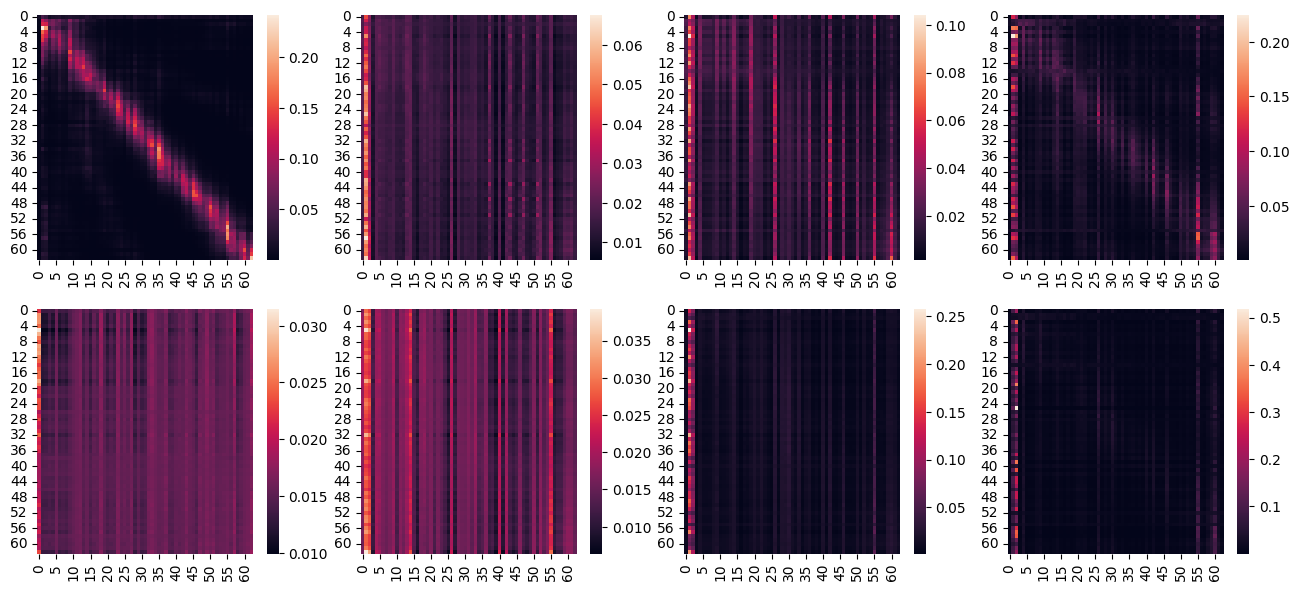

In [216]:
attn_scores = model.layers[1].encoder_layers[0].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])
        
plt.show()

In [217]:
test = pd.read_csv('/home/bibek/dataset/test.csv') 
test['cleaned_text'] = test.text.apply(lambda x: preprocess_text(x))


inp = test.cleaned_text.tolist()
inp = [tokenizer.tokenize(x) for x in inp]
inp = np.array([tokenizer.add_padding(x) for x in inp])

inp_x = tf.data.Dataset.from_tensor_slices(inp).batch(batch_size=batch)

preds = []
for i,x in enumerate(inp_x):
    
    p = np.round(model(x).numpy()[:,0])
    preds.extend(np.array(p,np.int16))


output = pd.DataFrame({'id':test.id,'target':preds})
output.to_csv('submission.csv',index=False)
